# Exercise 05) Temporal-Difference Learning

In this exercise we again use the racetrack environment developed in the first homework.
You can either use our provided environment or your own solution from the homework assignment.  

For starting, please execute the following cells. 
There, we will build the more complex rectangular course which was used in the last task of exercise 04.

A dummy policy is defined, which turns the car to the right in front of a wall.
As a reminder the action encoding can be seen in the following picture:

![](Directions_Legend.png)

In [1]:
import numpy as np
import random
import sys
from solution import RaceTrackEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_rect_course(course_dim, inner_wall_dim):
    """Build a race track given specifications for the outer cyclic street and inner wall dimensions.
    Start and finish line should be placed in the center top. The course dimension specifications
    do not consider a bounding wall around the track, which must be inserted additionally.
    
    Args:
        course_dim: 2-tuple, (y-dim, x-dim): The size of the track without outer walls.
        inner_wall_dim: 2-tuple (y-dim, x-dim): The size of the inner wall
    
    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'o'*half_street_len + '+W-' + 'o'*(half_street_len-1)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'o'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'o'*course_dim[1]
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW

 
 Sample trajectory on dummy policy:


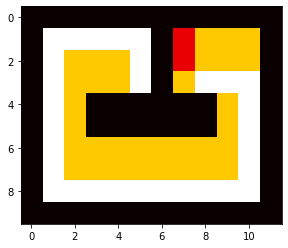

In [3]:
course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4 

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5 # turn right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # turn down left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # turn up left
dummy_slow_pi[track.bounds[0]//2:, :2, 0, :] = 2 # turn up right
dummy_slow_pi[:2, 0:track.bounds[1]//2, :, 0] = 8 # turn down right


pi = dummy_slow_pi

y_size, x_size = track.bounds

# Run learned policy on test case
pos_map = np.zeros((y_size, x_size))
p, v = track.reset()
for k in range(2000):
    s_y, s_x = p[0], p[1]
    s_vy, s_vx = v[0], v[1]
    pos_map[s_y, s_x] += 1  # exploration map
    act = track.action_to_tuple(pi[s_y, s_x, s_vy, s_vx])
    (p, v), rew, done, _ = track.step(act)
    if done: break    

for row in course:
    print(row)

print('\n \n Sample trajectory on dummy policy:')
pos_map = (pos_map > 0).astype(np.float32)
pos_map +=  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) TD-Based Policy Evaluation

Write a TD-based prediction algorithm to evaluate the dummy policy using $\alpha = 0.2$ and $\gamma = 1$ and calculate the state values.

After how many episodes do the state values converge?
Compare this to Monte-Carlo first visit prediciton from exercise 04.

Change $\alpha$ to $1$? Does it work? Explain!

## 1) Solution

episode:   0%|          | 0/250 [00:00<?, ?it/s]


 
 Estimated state values in episode 249: 

000 000 000 000 000 000 000 000 000 000 000 000
000 -04 -03 -02 -01 000 000 -30 -29 -28 -27 000
000 -05 000 000 000 000 000 -29 -28 -27 -26 000
000 -06 000 000 000 000 000 -28 -27 -26 -25 000
000 -07 000 000 000 000 000 000 000 000 -24 000
000 -08 000 000 000 000 000 000 000 000 -23 000
000 -09 000 000 000 000 000 000 000 000 -22 000
000 -10 000 000 000 000 000 000 000 000 -21 000
000 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 000
000 000 000 000 000 000 000 000 000 000 000 000


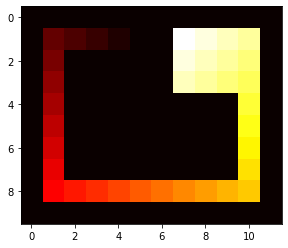

In [4]:
# Function to print the state values
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))

# Function to plot the heatmap 
def plot_pos_map(_pos_map):
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()

# Initialise state values 
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# Configuration parameters
gamma = 1
alpha = 1

# Initialise race track course
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

pos_map = np.zeros((y_size, x_size))

episodes = 250

# YOUR CODE HERE

for e in tqdm(range(episodes), desc='episode'):

  done = False

  #initilaize x0
  p, v = track.reset()

  # x0
  s_y, s_x = p[0], p[1]
  s_vy, s_vx = v[0], v[1] 
  state_tuple = s_y, s_x, s_vy, s_vx

  while not done:

    #applying action from policy pi(x_k)
    action = track.action_to_tuple(pi[state_tuple])

    #take step
    (p, v), reward, done, _ = track.step(action)

    #store x_k+1
    s_y, s_x = p[0], p[1]
    s_vy, s_vx = v[0], v[1]
    next_state_tuple = s_y, s_x, s_vy, s_vx

    #update state value
    values[state_tuple] += alpha * (reward + gamma*values[next_state_tuple]-values[state_tuple])

    #x_k = x_k+1
    state_tuple = next_state_tuple
    pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])


for s_x in range(x_size):
  for s_y in range(y_size):
    pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])

#print state values after each episode
print('\n \n Estimated state values in episode {}: \n'.format(e))
text_print_pos_map(pos_map)


# Plot heatmap in the end
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control: 

Write a temporal-difference based $\varepsilon$-greedy control algorithm to solve the rectangular course environment used above. 
Use $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$ and run $500$ episodes.

Note that no initial policy is needed for TD control methods. 


Does Sarsa perform good at learning an optimal greedy policy?

Change $\alpha$ to $0.1$ and $0.9$. What do you recognize? Explain!

## 2) Solution

YOUR ANSWER HERE

episode:   0%|          | 0/500 [00:00<?, ?it/s]

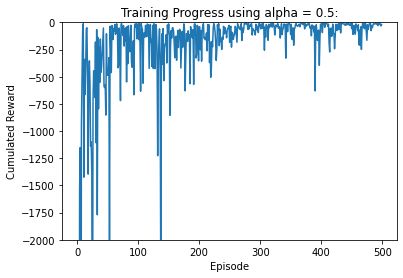

In [7]:
# Initialise action values 
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])

cumulated_rewards = []
q_sample = []

# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 0.5       # discount factor
alpha = 0.5     # forgetting factor
episodes = 500 # number of evaluated episodes

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

### BEGIN SOLUTION

for e in tqdm(range(episodes), desc='episode'): 
    cumulated_reward = 0
    done = False
    
    pos_map = np.zeros((y_size, x_size))
    
    p, v = track.reset()
    
    # x_k = x0
    s_y, s_x = p[0], p[1]
    s_vy, s_vx = v[0], v[1]
    state_tuple = s_y, s_x, s_vy, s_vx
    
    # Choose Initial Action greedy
    if epsilon < np.random.rand(1):
        # argmax takes action (in the range of [0,8] )with maximal propability in the state_tuple
        action = np.argmax(action_values[state_tuple])
    else:
        action = random.choice(range(9))
        
    # episodes do not terminate by time limit
    while not done:
        pos_map[s_y, s_x] += 1  # exploration map
        
        a = track.action_to_tuple(action)
        
        # save state_action tuple before step
        a_s = track.state_action((p, v), a)
        
        # take environment step
        (p, v), reward, done, _ = track.step(a)
        
        cumulated_reward += reward
        
        # x_k+1
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        state_tuple = s_y, s_x, s_vy, s_vx
        
        # choose action for next step
        if epsilon < np.random.rand(1):
            action = np.argmax(action_values[state_tuple])
        else:
            action = random.choice(range(9))
            
        a = track.action_to_tuple(action)
        
        # save state_action tuple after step
        next_a_s = track.state_action((p, v), a)
        
        # update action values
        action_values[a_s] += alpha * (reward + gamma*action_values[next_a_s]-action_values[a_s]) 
    
    cumulated_rewards.append(cumulated_reward)      
        
### END SOLUTION    
    
plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()


YOUR ANSWER HERE

In [8]:
# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.1     # forgetting factor
episodes = 400 # number of evaluated episodes
n_mean = 10

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)
    
q_sample1 = np.zeros([n_mean, episodes])
q_sample2 = np.zeros([n_mean, episodes])
q_sample3 = np.zeros([n_mean, episodes])

for ii in range(n_mean):
    # Initialise action values 
    action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])  

    for e in tqdm(range(episodes), desc='episode'): 
        
        done = False

        pos_map = np.zeros((y_size, x_size))

        p, v = track.reset()

        # x_k = x0
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        state_tuple = s_y, s_x, s_vy, s_vx

        # Choose Initial Action greedy
        if epsilon < np.random.rand(1):
            # argmax takes action (in the range of [0,8] )with maximal propability in the state_tuple
            action = np.argmax(action_values[state_tuple])
        else:
            action = random.choice(range(9))

        # episodes do not terminate by time limit
        while not done:
            pos_map[s_y, s_x] += 1  # exploration map

            a = track.action_to_tuple(action)

            # save state_action tuple before step
            a_s = track.state_action((p, v), a)

            # take environment step
            (p, v), reward, done, _ = track.step(a)

            

            # x_k+1
            s_y, s_x = p[0], p[1]
            s_vy, s_vx = v[0], v[1]
            state_tuple = s_y, s_x, s_vy, s_vx

            # choose action for next step
            if epsilon < np.random.rand(1):
                action = np.argmax(action_values[state_tuple])
            else:
                action = random.choice(range(9))
            
            a = track.action_to_tuple(action)
            
            # save state_action tuple after step
            next_a_s = track.state_action((p, v), a)

            # update action values
            action_values[a_s] += alpha * (reward + gamma*action_values[next_a_s]-action_values[a_s]) 

        q_sample1[ii, e] =  action_values[1,7,0,0,0,1]  # startline nach rechts
        q_sample2[ii, e] =  action_values[2,7,0,0,0,1]  # startline nach rechts
        q_sample3[ii, e] =  action_values[3,7,0,0,0,1]  # startline nach rechts

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

episode:   0%|          | 0/400 [00:00<?, ?it/s]

Use the following cell to plot the mean +- standard deviation from the action values stored above.
Try for different $\alpha$!

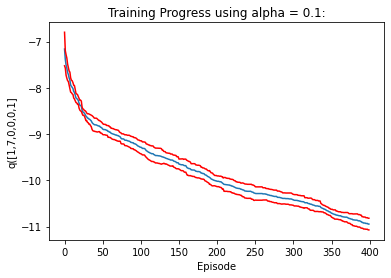

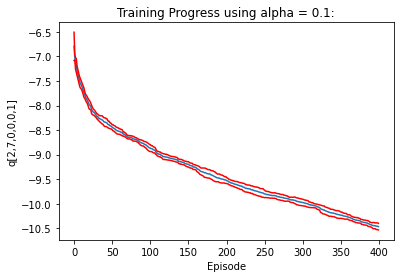

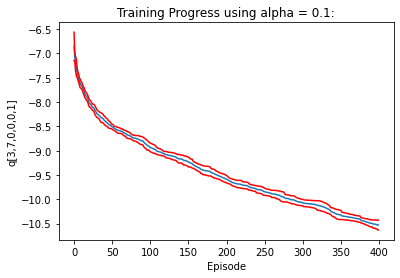

In [9]:
mean_q_sample1 = np.mean(q_sample1, axis = 0)
std_q_sample1 = np.std(q_sample1, axis = 0)

plt.plot(mean_q_sample1)
plt.plot(mean_q_sample1+std_q_sample1, 'r')
plt.plot(mean_q_sample1-std_q_sample1, 'r')
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('q([1,7,0,0,0,1]')
#plt.ylim(-20, 0) 
plt.show()

mean_q_sample2 = np.mean(q_sample2, axis = 0)
std_q_sample2 = np.std(q_sample2, axis = 0)

plt.plot(mean_q_sample2)
plt.plot(mean_q_sample2+std_q_sample2, 'r')
plt.plot(mean_q_sample2-std_q_sample2, 'r')
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('q[2,7,0,0,0,1]')
plt.show()

mean_q_sample3 = np.mean(q_sample3, axis = 0)
std_q_sample3 = np.std(q_sample3, axis = 0)

plt.plot(mean_q_sample3)
plt.plot(mean_q_sample3+std_q_sample3, 'r')
plt.plot(mean_q_sample3-std_q_sample3, 'r')
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('q[3,7,0,0,0,1]')
plt.show()

Use the following code to apply the best policy. Due to the random start position, do $5$ iterations.

Sample trajectory on learned policy in episode 0:


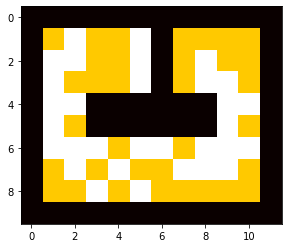

Sample trajectory on learned policy in episode 1:


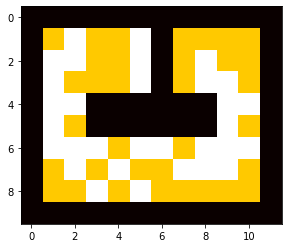

Sample trajectory on learned policy in episode 2:


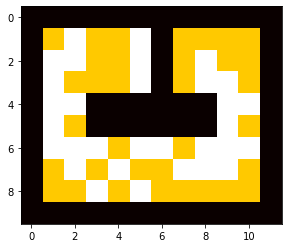

Sample trajectory on learned policy in episode 3:


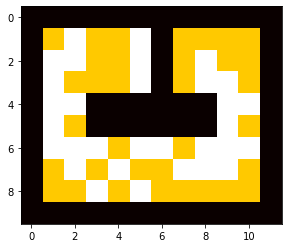

Sample trajectory on learned policy in episode 4:


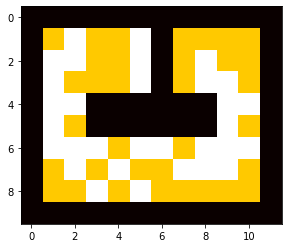

In [10]:
def evaluate_policy(policy, n_episodes=5):
    for e in range(n_episodes):
        action_states = []
        rewards = []

        pos_map = np.zeros((y_size, x_size))
        p, v = track.reset()
        for k in range(200):
            s_y, s_x = p[0], p[1]
            s_vy, s_vx = v[0], v[1]

            pos_map[s_y, s_x] += 1  # exploration map

            state_tuple = s_y, s_x, s_vy, s_vx
            action = np.argmax(policy[state_tuple])

            a = track.action_to_tuple(action)
            action_state = track.state_action((p, v), a)
            action_states.append(action_state)

            (p, v), reward, done, _ = track.step(a)
            rewards.append(reward)

            if done:
                print('Done')
                break 


        print('Sample trajectory on learned policy in episode {}:'.format(e))
        pos_map = (pos_map > 0).astype(np.int16)
        pos_map +=  track.course  # overlay track course
        plt.imshow(pos_map, cmap='hot', interpolation='nearest')
        plt.show()


evaluate_policy(action_values)

## 3) Off-Policy $\varepsilon$-Greedy Control: Q-Learning

Write a function for a Q-Learning algorithm to solve the rectangular course environment (function will be re-used in the next task).
Use again $\varepsilon = 0.1$, $\alpha = 0.5$, $\gamma = 1$ and 500 episodes.

Can the resulting greedy policy be expected to be better or worse than the optimal policy trained with Sarsa?


## 3) Solution

YOUR ANSWER HERE

episode:   0%|          | 0/500 [00:00<?, ?it/s]

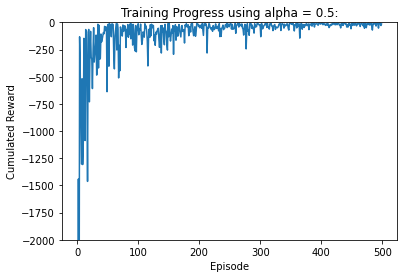

In [11]:
  
def q_learning(epsilon, gamma, alpha, episodes, track):
    """
    Defines the Q-learning function which performs 𝜀-greedy control on the given track.

    :epsilon:  exploration probability
    :gamma:    discount factor
    :alpha:    forgetting factor
    :episodes: number of evaluated episodes
    :tack:     race track to learn
    
    :return: list of cummulated rewards per episode
    """
    # Initialise action values 
    action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []

    # YOUR CODE HERE
 
    for e in tqdm(range(episodes), desc='episode'): 
        cumulated_reward = 0
        done = False

        pos_map = np.zeros((y_size, x_size))
        p, v = track.reset()   
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        # episodes do not terminate by time limit
        while not done:

            # take step
            
            pos_map[s_y, s_x] += 1  # exploration map
            state_tuple = s_y, s_x, s_vy, s_vx
            # choose action for next step
            if epsilon < np.random.rand(1):
                action = np.argmax(action_values[state_tuple])
            else:
                action = random.choice(range(9))
            a = track.action_to_tuple(action)

            a_s = track.state_action((p, v), a)
            (p, v), reward, done, _ = track.step(a)

            # Sum up reward
            cumulated_reward += reward
            
            # save state tuple after step and update action values
            s_y, s_x = p[0], p[1]
            s_vy, s_vx = v[0], v[1]
            next_s  = s_y, s_x, s_vy, s_vx
            action_values[a_s] += alpha * (reward + gamma*np.max(action_values[next_s])-action_values[a_s]) 

        #print(cumulated_reward)
        cumulated_rewards.append(cumulated_reward) 
        
    return cumulated_rewards, action_values
    
# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.5      # forgetting factor
episodes = 500 # number of evaluated episodes

# define track using the course defined above
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)

plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()


Show again the best 5 episodes using the function defined in 2)

Done
Sample trajectory on learned policy in episode 0:


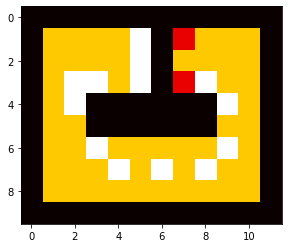

Done
Sample trajectory on learned policy in episode 1:


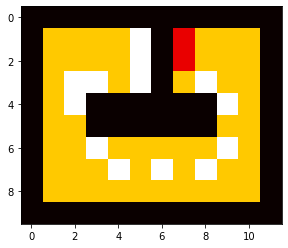

Done
Sample trajectory on learned policy in episode 2:


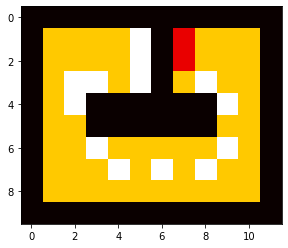

Done
Sample trajectory on learned policy in episode 3:


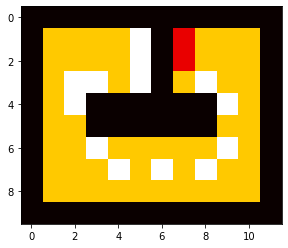

Done
Sample trajectory on learned policy in episode 4:


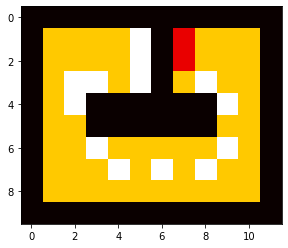

In [12]:
evaluate_policy(action_values)

## 4) Double Q-Learning

Now assume the driver had a few beers. Due to the alcohol he/she is not able to perceive the environment in detail.
The reward is therefore stochastic whenever an action, that accelerates the car into the direction of a corner, is selected (e.g. [-1,1] in the upper right quadrant).
Therefore a stochastic environment is given below. 
Execute the cell before continuing with the exercise.

- Use this environment and try to solve it with the Q-learning function written in 3) using $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$ with the cells given below.

A code template is given which repeats the training $3$ times to calculate the mean cumulated reward.


- Write a double Q-learning algorithm to solve the above defined course with the given template.
Use again $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$.

Compare the results.

### Drunken Driver Environment

In [13]:
class StochRaceTrackEnv(RaceTrackEnv):
    """
    Driver is not able to perceive the environment clearly anymore
    """
    def __init__(self, eps=0.2, **kwargs):
        self.eps = eps        
        super().__init__(**kwargs)
        # centrifugal acceleration map
        self.cam = np.zeros((2,) + self.course.shape, dtype=int)
        self.cam[0, :self.course.shape[0]//2, :] = -1
        self.cam[0, self.course.shape[0]//2:, :] = 1
        self.cam[1, :, :self.course.shape[1]//2] = -1
        self.cam[1, :, self.course.shape[1]//2:] = 1
        
        
    def step(self, action):
        if isinstance(action, int):
            action = self.action_to_tuple(action)
        
        prev_p, prev_v = tuple(self.position), tuple(self.velocity)
        
        
        (p, v), reward, done, _ = super().step(action)
        
        # sample random reward if centrifugal acceleration applies
        if action[0] == self.cam[0, prev_p[0], prev_p[1]] and action[1] == self.cam[1, prev_p[0], prev_p[1]]:
            reward += np.random.randn()

        return (p, v), reward, done, _

Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

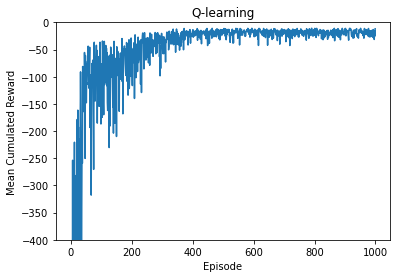

In [14]:
# configuration parameters
epsilon = 0.1    # exploration probability
gamma = 1        # discount factor
alpha = 0.5      # forgetting factor
episodes = 1000  # number of evaluated episodes
repetitions = 4  # repeats the training to get mean reward

# define track using the course defined above
track = StochRaceTrackEnv(course=course)

reward_trajectories_Q = []
policies_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute q-learning
    cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_Q.append(cumulated_rewards)
    policies_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0))
plt.title('Q-learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.show()



Done
Sample trajectory on learned policy in episode 0:


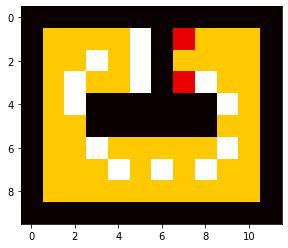

Done
Sample trajectory on learned policy in episode 1:


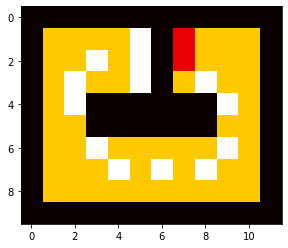

Done
Sample trajectory on learned policy in episode 2:


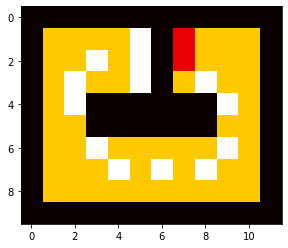

Done
Sample trajectory on learned policy in episode 3:


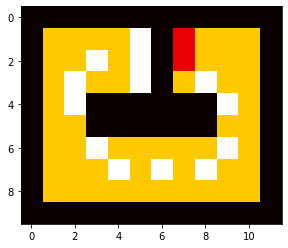

Done
Sample trajectory on learned policy in episode 4:


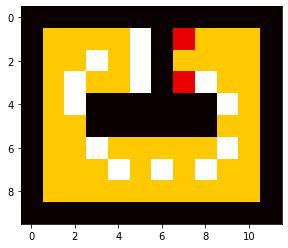

Done
Sample trajectory on learned policy in episode 5:


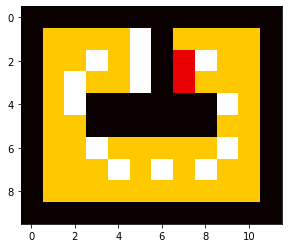

Done
Sample trajectory on learned policy in episode 6:


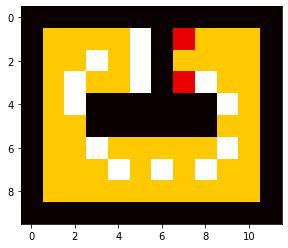

Done
Sample trajectory on learned policy in episode 7:


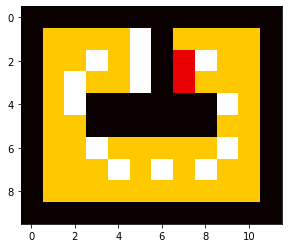

Done
Sample trajectory on learned policy in episode 8:


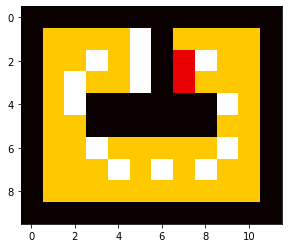

Done
Sample trajectory on learned policy in episode 9:


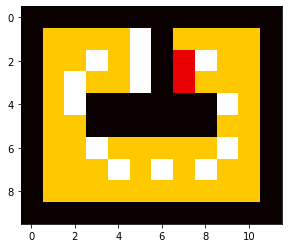

In [15]:
# show episodes
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_Q[-1], 10)

YOUR ANSWER HERE

Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

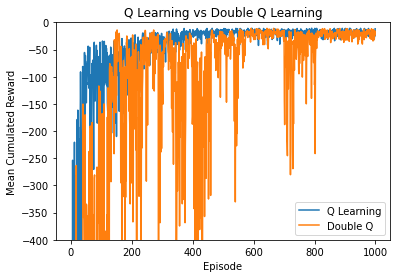

In [16]:
def double_q_learning(_epsilon, _gamma, _alpha, _episodes, _track):
    """
    Defines the Q-learning function which performs 𝜀-greedy control on the given track.

    :_epsilon:  exploration probability
    :_gamma:    discount factor
    :_alpha:    forgetting factor
    :_episodes: number of evaluated episodes
    :_tack:     race track to learn
    
    :return: list of cummulated rewards per episode and action values
    """
    
    # define track
    course = _track.course
    x_size, y_size = len(course[0]), len(course)
    
    # Initialise action values 
    action_values1 = np.zeros([_track.bounds[0], _track.bounds[1], 1+2*_track.MAX_VELOCITY, 1+2*_track.MAX_VELOCITY, 3, 3])
    action_values2 = np.zeros([_track.bounds[0], _track.bounds[1], 1+2*_track.MAX_VELOCITY, 1+2*_track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []
    
    ### BEGIN SOLUTION
    
    for e in tqdm(range(_episodes), desc='episode'): 
        
        cumulated_reward = 0
        done = False

        pos_map = np.zeros((y_size, x_size))
        p, v = _track.reset()     
        s_y, s_x = p[0], p[1]
        
        # episodes do not terminate by time limit
        while not done:
            pos_map[s_y, s_x] += 1  # exploration map

            
            s_y, s_x = p[0], p[1]
            s_vy, s_vx = v[0], v[1]
            state_tuple = s_y, s_x, s_vy, s_vx
            
            # choose action for next step
            if _epsilon < np.random.rand():
                action = np.argmax(action_values1[state_tuple]+action_values2[state_tuple])
            else:
                action = np.random.randint(9)
            a = _track.action_to_tuple(action)

            a_s = _track.state_action((p, v), a)
            
            # take step
            (p, v), reward, done, _ = _track.step(a)
            
            # save state tuple after step and update action values
            s_y, s_x = p[0], p[1]
            s_vy, s_vx = v[0], v[1]
            next_s  = s_y, s_x, s_vy, s_vx
            
            if np.random.rand() > 0.5:
                q2_argmax_q1 = np.ravel(action_values2[next_s])[np.argmax(action_values1[next_s])]
                action_values1[a_s] += _alpha * (reward + _gamma*q2_argmax_q1-action_values1[a_s])
            else:
                q1_argmax_q2 = np.ravel(action_values1[next_s])[np.argmax(action_values2[next_s])]
                action_values2[a_s] += _alpha * (reward + _gamma*q1_argmax_q2-action_values2[a_s]) 

            cumulated_reward += reward

        cumulated_rewards.append(cumulated_reward)      
        
    ### END SOLUTION
    
    return cumulated_rewards, action_values1+action_values2


reward_trajectories_double_Q = []
policies_double_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute double q-learning
    cumulated_rewards, action_values = double_q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_double_Q.append(cumulated_rewards)
    policies_double_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0), label='Q Learning')
plt.plot(np.vstack(reward_trajectories_double_Q).mean(axis=0), label='Double Q')
plt.title('Q Learning vs Double Q Learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.legend()
plt.show()

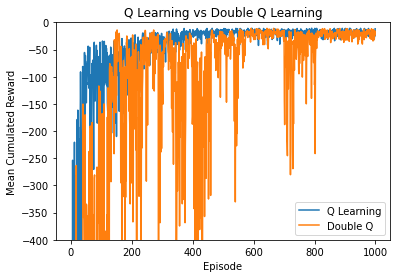

In [18]:
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0), label='Q Learning')
plt.plot(np.vstack(reward_trajectories_double_Q).mean(axis=0), label='Double Q')
plt.title('Q Learning vs Double Q Learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.legend()
plt.show()

Show again the best $5$ episodes using the function defined in 2).

Done
Sample trajectory on learned policy in episode 0:


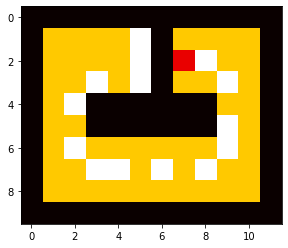

Done
Sample trajectory on learned policy in episode 1:


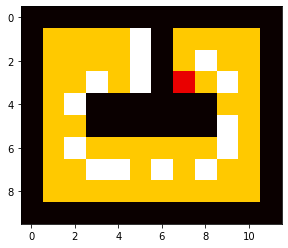

Done
Sample trajectory on learned policy in episode 2:


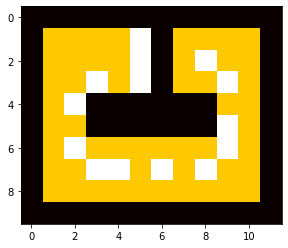

Done
Sample trajectory on learned policy in episode 3:


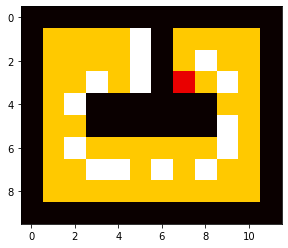

Done
Sample trajectory on learned policy in episode 4:


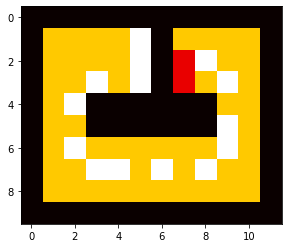

Done
Sample trajectory on learned policy in episode 5:


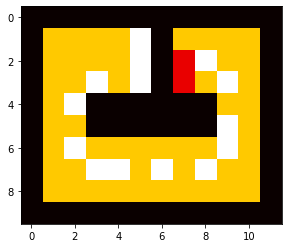

Done
Sample trajectory on learned policy in episode 6:


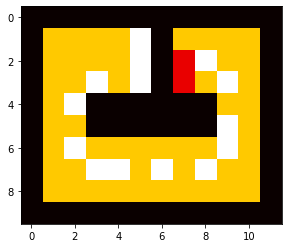

Done
Sample trajectory on learned policy in episode 7:


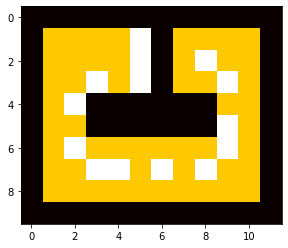

Done
Sample trajectory on learned policy in episode 8:


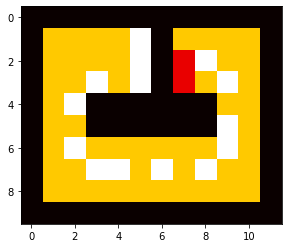

Done
Sample trajectory on learned policy in episode 9:


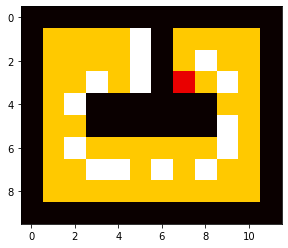

In [17]:
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_double_Q[-1], 10)